# Deploying Our Model

This file deploys our trained model by feeding live images using OpenCV. We use a cascade classifier to detect the face(s) from a webcam and feed the face image into our CNN. Our CNN returns a result (mask, no mask, incorrectly worn mask) and we display the result back onto the screen.

In [6]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [2]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

## Test On Static Image
First test the cascade classifier on a static image as videos are a series of static images.

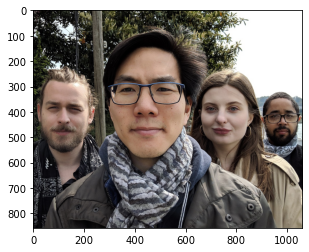

In [32]:
#Load image
input_img = cv2.imread('selfie.jpg')
#Plot image
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.show()

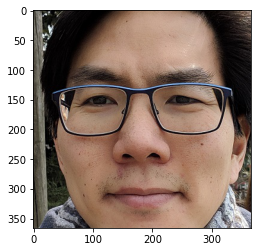

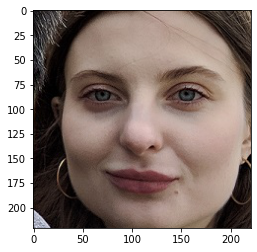

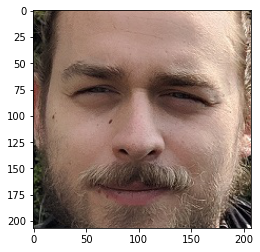

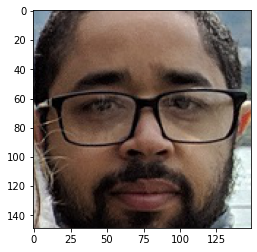

In [33]:
#Extract faces
gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
faces = face_detector.detectMultiScale(gray, scaleFactor=1.2, minNeighbors =5)

for (x, y, w, h) in faces:
    output = input_img[y:y+h, x:x+w]
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()

## Test On Live 
First we need to re-define our CNN models

In [3]:
# Create a neural net class
class CNN_V2(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V2, self).__init__()
        self.name = "CNN_V2"
        
        # Our images are RGB, so we have input channels = 3. 
        #12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240 image tensors will be pooled twice with a kernel size of 2. 240/2/2 is 60.
        # Thus 60x60 tensors and 24 tensors
        self.fc = nn.Linear(in_features=60 * 60 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 60 * 60 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)

In [3]:
class CNN_V3(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V3, self).__init__()
        self.name = "CNN_V3"
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=4, padding=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=6, stride=1)
        
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240x3 ==conv1=> 60x60x64 ==4 conv layers=> 40x40x64
        self.fc = nn.Linear(in_features=40*40*64, out_features=num_classes)

    def forward(self, x):
        # Convolution with large kernel + stride to prevent need for max pooling (maintains accuracy and speeds up training)
        x = F.relu(self.conv1(x)) 
        
        # 64 feature convolutional layers
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv2(x))  

        # Dropout layer
        x = F.dropout(self.drop(x), training=self.training)
        
        x = x.view(-1, 40*40*64)
        x = self.fc(x)
        
        return torch.log_softmax(x, dim=1)

## Load Deployable Model
Here we load the deployable model from our models folder. This model will be receiving live data from OpenCV

In [4]:
model = CNN_V3()
#model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V2", 32, 0.0001, 18)
model_path = "models/best_model"
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [5]:
labels_dict={0:'INCORRECT MASK',1:'MASK',2:'NO MASK'} 
color_dict={0:(0,255,255),1:(0,255,0),2:(0,0,255)} #BGR color codes

In [ ]:
source = cv2.VideoCapture(1) #Change parameter if you have different webcams, 0 for default
source.set(15, -2)
softmax = nn.Softmax()
try: 
    while(True):    

        #Read from webcam
        ret,img = source.read()

        #OpenCV convert to grayscale for haarcascade classifier
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, scaleFactor=1.09, minNeighbors = 5)

        #OpenCV convert to BGR to RGB for CNN
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Iterate through all faces detected
        for (x, y, w, h) in faces:

            x = x - int(w/8)
            if x < 0:
                x = 0
            w = w + int(w/3)
            y = y - int(h/4)
            if y < 0:
                y = 0
            h = h + int(h/2)

            #Boundaries for face
            rgb_face = rgb[y:y+w, x:x+w]

            #Resize & Normalize
            resized_face_img = cv2.resize(rgb_face, (240,240)) /255.0

            #Reshape tensor
            model_input = torch.tensor(resized_face_img).unsqueeze(0).permute(0,3,1,2) 

            #Model Prediction
            output = model(model_input.float())
            pred, label = [_.sum().item() for _ in softmax(output).max(1, keepdim=True)]

            #Draws boxes around faces
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[label], 2)
            cv2.rectangle(img, (x, y+h), (x+100, y+h+20), (0, 0, 0), 1)
            cv2.putText(img, labels_dict[label] + " {:.2f}%".format(pred*100), (x, y + h + 20),cv2.FONT_HERSHEY_DUPLEX,0.5,color_dict[label],1)


        cv2.imshow('Detecting Masks... Press esc to exit',img)
        key=cv2.waitKey(30)

        #Exit - Esc key
        if(key==27):
            break
finally:
    cv2.destroyAllWindows()

<ipython-input-6-d8247745e764>:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred, label = [_.sum().item() for _ in softmax(output).max(1, keepdim=True)]
